In [ ]:
%matplotlib notebook

## ver1

### How it Works

### Initialization
Agents are initiated with these parameter
- Base wealth pulled from normal distribution
- Grid assigned abse price of 100
- Economic center (city center)

Then the grid price adjusted based on the distance to the nearest economic center

### Movement

Movement is still random (try to find a better way). and only move if can afford
###

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

class SchellingModel:
    def __init__(self, grid_size, n_agents, n_types, similarity_threshold, max_iterations=1000, max_distance=10):
        if n_agents > grid_size * grid_size:
            raise ValueError("Agents cannot exceed the grid size.")
        if not (0 <= similarity_threshold <= 1):
            raise ValueError("Similarity threshold must be between 0 and 1.")
        self.grid_size = grid_size
        self.n_agents = n_agents
        self.n_types = n_types
        self.similarity_threshold = similarity_threshold
        self.max_iterations = max_iterations
        self.max_distance = max_distance  # Maximum distance for movement
        self.grid = np.zeros((grid_size, grid_size), dtype=int)
        self.store = []
        self.agents = []
        self.money = {}  # Dictionary to store money for each agent
        self.grid_costs = np.full((grid_size, grid_size), 100)  # Initialize all grid prices to 100
        self.base_wealth = np.clip(np.random.normal(loc=50, scale=15, size=n_agents), 1, 100)  # Base wealth for agents
        self.economic_centers = [(self.grid_size//2, self.grid_size//2)]  # High-wage areas

    def initialize_grid(self):
        positions = np.random.choice(self.grid_size * self.grid_size, self.n_agents, replace=False)
        for idx, pos in enumerate(positions):
            x, y = divmod(pos, self.grid_size)
            agent_type = np.random.randint(1, self.n_types + 1)
            self.grid[x, y] = agent_type
            self.agents.append((x, y, agent_type))
            self.money[(x, y)] = self.base_wealth[idx]  # Assign base wealth

        # Initialize grid prices based on distance to the center
        center_x, center_y = self.economic_centers[0]
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                distance = 1 + ((x - center_x) * 2 + (y - center_y) * 2)
                self.grid_costs[x, y] += int(distance * 20)  # Increase price based on distance

    def get_neighbors(self, x, y):
        neighbors = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                if i == 0 and j == 0:
                    continue
                nx, ny = x + i, y + j
                if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                    neighbors.append(self.grid[nx, ny])
        return neighbors

    def is_satisfied(self, x, y, agent_type):
        neighbors = self.get_neighbors(x, y)
        if not neighbors:
            return False
        similar_neighbors = sum(1 for n in neighbors if n == agent_type)
        similarity_ratio = similar_neighbors / len(neighbors)
        return similarity_ratio >= self.similarity_threshold

    def update_house_prices(self):
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if self.grid[x, y] == 0:
                    neighbors = self.get_neighbors(x, y)
                    num_agents = sum(1 for n in neighbors if n != 0)
                    similarity = sum(1 for n in neighbors if n == self.grid[x, y]) / len(neighbors) if neighbors else 0
                    self.grid_costs[x, y] += (num_agents * 2) + (similarity * 10)  # Increase price based on similarity
                    self.grid_costs[x, y] = np.clip(self.grid_costs[x, y], 100, 10000)  # Keep prices within a range

    def update_wages(self):
        for idx, (x, y, _) in enumerate(self.agents):
            self.money[(x, y)] += self.base_wealth[idx] * 0.1  # Update wealth based on base wealth

    def move_agent(self, agent_idx):
        x, y, agent_type = self.agents[agent_idx]
        
        # Check if the agent is unsatisfied
        if not self.is_satisfied(x, y, agent_type):
            # Randomly select a new position within the grid
            new_x, new_y = np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size)
            
            # Check if the new position is empty and if the agent can afford to move there
            if self.grid[new_x, new_y] == 0 and self.money[(x, y)] >= self.grid_costs[new_x, new_y]:
                # Move the agent to the new position
                self.grid[x, y] = 0
                self.grid[new_x, new_y] = agent_type
                self.agents[agent_idx] = (new_x, new_y, agent_type)
                self.money[(new_x, new_y)] = self.money[(x, y)] - self.grid_costs[new_x, new_y]
                del self.money[(x, y)]

    def run(self):
        self.initialize_grid()
        for iteration in range(self.max_iterations):
            self.store.append(self.grid.copy())
            if iteration % 100 == 0:  # Update grid prices every 500 iterations
                self.update_house_prices()
            if iteration % 5 == 0:  # Update wages every 5 iterations
                self.update_wages()
            np.random.shuffle(self.agents)
            for agent_idx in range(len(self.agents)):
                self.move_agent(agent_idx)
            if all(self.is_satisfied(x, y, agent_type) for x, y, agent_type in self.agents):
                print(f"Converged after {iteration + 1} iterations")
                break
        else:
            print(f"Reached maximum iterations ({self.max_iterations})")
            
    def plot_grid(self):
        # Define a colormap with distinct colors
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        plt.imshow(self.grid, cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        # Create a legend
        legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='white', markersize=10, label='Empty'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Type 1'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='Type 2')]
        plt.legend(handles=legend_elements, loc='upper right')
        plt.show()

    def create_animation(self, save_path=None):
        fig, ax = plt.subplots()
        # Define a colormap with distinct colors
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        im = ax.imshow(self.store[0], cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        # Create a legend
        legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='white', markersize=10, label='Empty'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Type 1'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='Type 2')]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.colorbar(im)

        def update(frame):
            im.set_data(self.store[frame])
            return [im]

        anim = animation.FuncAnimation(
            fig, 
            update, 
            frames=len(self.store), 
            interval=100, 
            blit=True
        )
        display(fig)
        plt.show()

        if save_path:
            try:
                if save_path.endswith('.mp4'):
                    writer = animation.FFMpegWriter(fps=10)  
                    anim.save(save_path, writer=writer)
                elif save_path.endswith('.gif'):
                    writer = animation.PillowWriter(fps=10)  
                    anim.save(save_path, writer=writer)
                else:
                    raise ValueError("Unsupported file format. Use '.mp4' or '.gif'.")
                print(f"Animation saved to {save_path}")
            except Exception as e:
                print(f"Failed to save animation: {e}")
                
    def plot_last_state(self):
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        plt.figure(figsize=(6, 6))
        plt.imshow(self.grid, cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        plt.title("Final State of the Grid")
        plt.colorbar(label="Agent Type")
        plt.show()

    def plot_agents_wealth(self):
        wealth_grid = np.zeros((self.grid_size, self.grid_size), dtype=float)
        
        for (x, y), money in self.money.items():
            wealth_grid[x, y] = money
        
        plt.figure(figsize=(6, 6))
        plt.imshow(wealth_grid, cmap='viridis', interpolation='none')
        plt.title("Agents' Wealth Distribution")
        plt.colorbar(label="Wealth")
        plt.show()

    def plot_grid_costs(self):
        """
        Plots the grid costs as a heatmap.
        """
        plt.figure(figsize=(6, 6))
        plt.imshow(self.grid_costs, cmap='viridis', interpolation='none')
        plt.title("Grid Costs")
        plt.colorbar(label="Cost")
        plt.show()

Reached maximum iterations (1000)


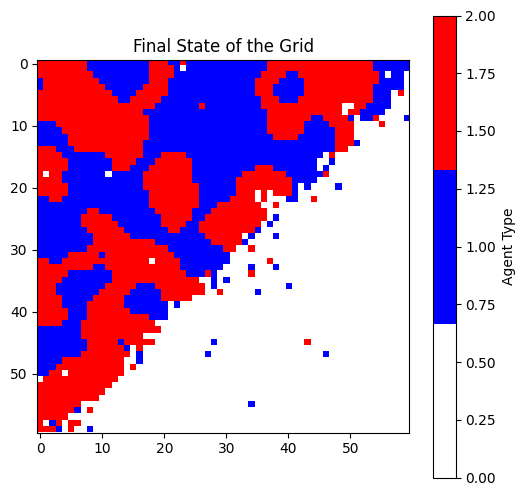

In [82]:
model = SchellingModel(grid_size=60, n_agents=2000, n_types=2, similarity_threshold=0.5)
model.run()
#model.create_animation(save_path='schelling_animationv6.mp4')
model.plot_last_state()


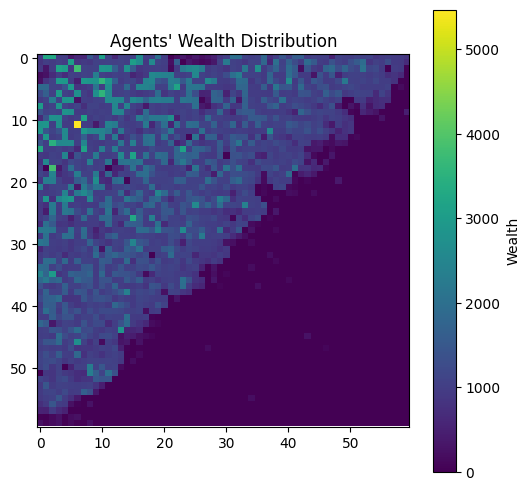

In [83]:
model.plot_agents_wealth() 

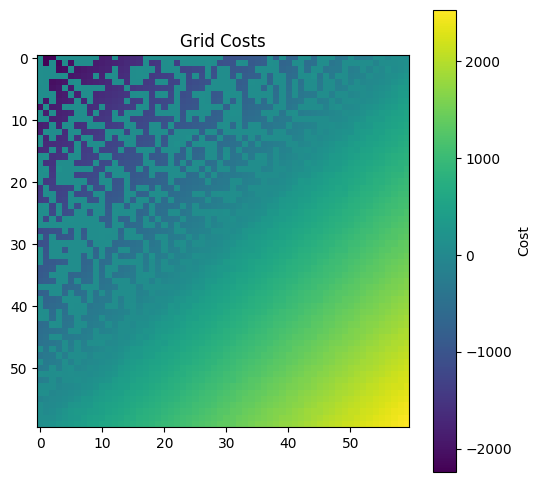

In [84]:
model.plot_grid_costs ()

## ver2

### **Key Concepts and Calculations**

1. **Grid and Agents**:
   - The model uses a grid to represent a spatial environment.
   - Agents are placed on the grid, each belonging to one of several types (e.g., Type 1, Type 2).

2. **Similarity Threshold**:
   - Agents are satisfied if a certain fraction of their neighbors are of the same type.
   - For example, if the threshold is 0.5, an agent wants at least 50% of its neighbors to be of the same type.

3. **Wealth and Wages**:
   - Each agent has a wealth value, initialized using a log-normal distribution (skewed towards lower values but with some high earners).
   - Wages are added to agents' wealth periodically, simulating income.

4. **House Pricing**:
   - The cost of a house depends on the number of "rich" neighbors (agents with wealth above a threshold).
   - House prices increase with more rich neighbors, simulating demand in affluent areas.

5. **Agent Movement**:
   - Unsatisfied agents move to a nearby empty cell if they can afford the cost.
   - Movement is limited to a maximum distance, and agents pay the cost of the new cell from their wealth.

6. **Convergence**:
   - The simulation stops when all agents are satisfied or when the maximum number of iterations is reached.

7. **Visualization**:
   - The grid is visualized using colors to represent agent types.
   - Wealth distribution and house prices are plotted to analyze economic patterns.

### **Key Calculations**:
1. **Similarity Ratio**:
   - For an agent at `(x, y)`, calculate the fraction of neighbors of the same type.
   - If this fraction ≥ similarity threshold, the agent is satisfied.

2. **House Price**:
   - For each empty cell, count the number of rich neighbors.
   - Price = Base Price + (3 × Number of Rich Neighbors).
   - Prices are capped between 50 and 200.

3. **Wealth Update**:
   - Every 5 iterations, add the agent's initial wage to their wealth.

4. **Movement Cost**:
   - Agents pay the cost of the new cell from their wealth.
   - If wealth < cost, the agent cannot move.

5. **Convergence Check**:
   - Stop the simulation if all agents are satisfied or the maximum iterations are reached.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

class SchellingModel:
    def __init__(self, grid_size, n_agents, n_types, similarity_threshold, max_iterations=1000):
        if n_agents > grid_size * grid_size:
            raise ValueError("Agents cannot exceed the grid size.")
        if not (0 <= similarity_threshold <= 1):
            raise ValueError("Similarity threshold must be between 0 and 1.")
        self.grid_size = grid_size
        self.n_agents = n_agents
        self.n_types = n_types
        self.similarity_threshold = similarity_threshold
        self.max_iterations = max_iterations
        self.grid = np.zeros((grid_size, grid_size), dtype=int)
        self.store = []
        self.agents = []
        self.money = {}  # Dictionary to store money for each agent
        self.grid_costs = np.random.randint(50, 101, size=(grid_size, grid_size))
        self.base_price = 75  # Base price for houses
        self.initial_wages = self.generate_initial_wages()  # Store initial wages for each agent

    def generate_initial_wages(self):
        # Generate a log-normal distribution for initial wages
        mu, sigma = 3.0, 0.5  # Parameters for the log-normal distribution
        wages = np.random.lognormal(mu, sigma, self.n_agents)
        wages = np.clip(wages, 50, 100)  # Clip wages to a reasonable range
        return wages

    def initialize_grid(self):
        positions = np.random.choice(self.grid_size * self.grid_size, self.n_agents, replace=False)
        for idx, pos in enumerate(positions):
            x, y = divmod(pos, self.grid_size)
            agent_type = np.random.randint(1, self.n_types + 1)
            self.grid[x, y] = agent_type
            self.agents.append((x, y, agent_type))
            self.money[(x, y)] = self.initial_wages[idx]  # Assign initial wage as wealth

    def get_neighbors(self, x, y):
        neighbors = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                if i == 0 and j == 0:
                    continue
                nx, ny = x + i, y + j
                if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                    neighbors.append((nx, ny))
        return neighbors

    def is_satisfied(self, x, y, agent_type):
        neighbors = self.get_neighbors(x, y)
        if not neighbors:
            return False
        similar_neighbors = sum(1 for (nx, ny) in neighbors if self.grid[nx, ny] == agent_type)
        similarity_ratio = similar_neighbors / len(neighbors)
        return similarity_ratio >= self.similarity_threshold

    def update_house_prices(self):
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if self.grid[x, y] == 0:
                    neighbors = self.get_neighbors(x, y)
                    num_rich_neighbors = sum(1 for (nx, ny) in neighbors if self.money.get((nx, ny), 0) > 1000)  # Define "rich" as having more than 20 units of money
                    price = self.base_price + (3 * num_rich_neighbors)
                    self.grid_costs[x, y] = np.clip(price, 50, 200)

    def update_wages(self):
        # Every 5 iterations, add the initial wage to each agent's wealth
        for idx, (x, y, _) in enumerate(self.agents):
            self.money[(x, y)] += self.initial_wages[idx]

    def move_agent(self, agent_idx, max_distance=2):
        x, y, agent_type = self.agents[agent_idx]
        
        if not self.is_satisfied(x, y, agent_type):
            empty_cells = []
            for i in range(-max_distance, max_distance + 1):
                for j in range(-max_distance, max_distance + 1):
                    if i == 0 and j == 0:
                        continue
                    nx, ny = x + i, y + j
                    if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size and self.grid[nx, ny] == 0:
                        empty_cells.append((nx, ny))
            
            if empty_cells:
                new_x, new_y = empty_cells[np.random.choice(len(empty_cells))]
                cost = self.grid_costs[new_x, new_y]
                if self.money[(x, y)] >= cost:
                    self.money[(x, y)] -= cost
                    self.grid[x, y] = 0
                    self.grid[new_x, new_y] = agent_type
                    self.agents[agent_idx] = (new_x, new_y, agent_type)
                    self.money[(new_x, new_y)] = self.money[(x, y)]
                    del self.money[(x, y)]

    def run(self):
        self.initialize_grid()
        for iteration in range(self.max_iterations):
            self.store.append(self.grid.copy())
            self.update_house_prices()
            if iteration % 5 == 0:  # Update wages every 5 iterations
                self.update_wages()
            
            if iteration % 200 == 0:
                for x, y, _ in self.agents:
                    if (x, y) in self.money:
                        cost = self.grid_costs[x, y]
                        self.money[(x, y)] -= cost
                        if self.money[(x, y)] < 0:
                            self.money[(x, y)] = 0
                            print(f"Agent at ({x}, {y}) ran out of money!")
            np.random.shuffle(self.agents)

            for agent_idx in range(len(self.agents)):
                self.move_agent(agent_idx)
            if all(self.is_satisfied(x, y, agent_type) for x, y, agent_type in self.agents):
                print(f"Converged after {iteration + 1} iterations")
                break
        else:
            print(f"Reached maximum iterations ({self.max_iterations})")
            
    def plot_grid(self):
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        plt.imshow(self.grid, cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='white', markersize=10, label='Empty'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Type 1'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='Type 2')]
        plt.legend(handles=legend_elements, loc='upper right')
        plt.show()

    def create_animation(self, save_path=None):
        fig, ax = plt.subplots()
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        im = ax.imshow(self.store[0], cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='white', markersize=10, label='Empty'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Type 1'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='Type 2')]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.colorbar(im)

        def update(frame):
            im.set_data(self.store[frame])
            return [im]

        anim = animation.FuncAnimation(
            fig, 
            update, 
            frames=len(self.store), 
            interval=100, 
            blit=True
        )
        display(fig)
        plt.show()

        if save_path:
            try:
                if save_path.endswith('.mp4'):
                    writer = animation.FFMpegWriter(fps=10)  
                    anim.save(save_path, writer=writer)
                elif save_path.endswith('.gif'):
                    writer = animation.PillowWriter(fps=10)  
                    anim.save(save_path, writer=writer)
                else:
                    raise ValueError("Unsupported file format. Use '.mp4' or '.gif'.")
                print(f"Animation saved to {save_path}")
            except Exception as e:
                print(f"Failed to save animation: {e}")

    def plot_last_state(self):
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        plt.figure(figsize=(6, 6))
        plt.imshow(self.grid, cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        plt.title("Final State of the Grid")
        plt.colorbar(label="Agent Type")
        plt.show()

    def plot_agents_wealth(self):
        wealth_grid = np.zeros((self.grid_size, self.grid_size), dtype=float)
        
        for (x, y), money in self.money.items():
            wealth_grid[x, y] = money
        
        plt.figure(figsize=(6, 6))
        plt.imshow(wealth_grid, cmap='viridis', interpolation='none')
        plt.title("Agents' Wealth Distribution")
        plt.colorbar(label="Wealth")
        plt.show()

    def plot_grid_costs(self):
        plt.figure(figsize=(6, 6))
        plt.imshow(self.grid_costs, cmap='viridis', interpolation='none')
        plt.title("Grid Costs")
        plt.colorbar(label="Cost")
        plt.show()

Agent at (24, 24) ran out of money!
Agent at (28, 39) ran out of money!
Agent at (9, 25) ran out of money!
Agent at (35, 7) ran out of money!
Agent at (18, 6) ran out of money!
Agent at (8, 21) ran out of money!
Agent at (9, 26) ran out of money!
Agent at (33, 12) ran out of money!
Agent at (31, 37) ran out of money!
Agent at (14, 12) ran out of money!
Agent at (9, 34) ran out of money!
Agent at (6, 33) ran out of money!
Agent at (2, 27) ran out of money!
Agent at (29, 2) ran out of money!
Agent at (38, 15) ran out of money!
Agent at (34, 23) ran out of money!
Agent at (23, 14) ran out of money!
Agent at (36, 23) ran out of money!
Agent at (2, 9) ran out of money!
Agent at (13, 35) ran out of money!
Agent at (33, 1) ran out of money!
Agent at (4, 12) ran out of money!
Agent at (21, 29) ran out of money!
Agent at (1, 15) ran out of money!
Agent at (11, 7) ran out of money!
Agent at (11, 17) ran out of money!
Agent at (32, 21) ran out of money!
Agent at (32, 18) ran out of money!
Agent a

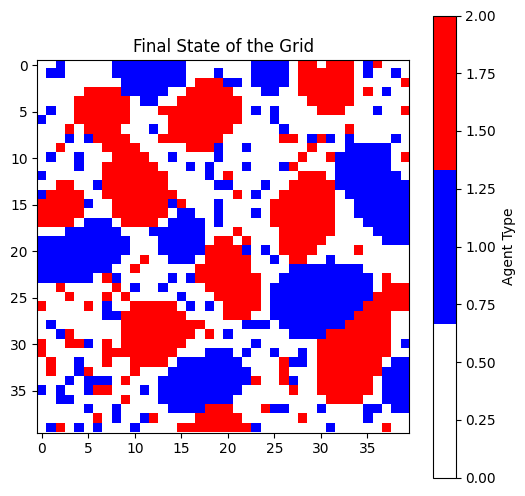

In [30]:
model = SchellingModel(grid_size=40, n_agents=900, n_types=2, similarity_threshold=0.5)
model.run()
#model.create_animation(save_path='schelling_animationver3.mp4')
model.plot_last_state()

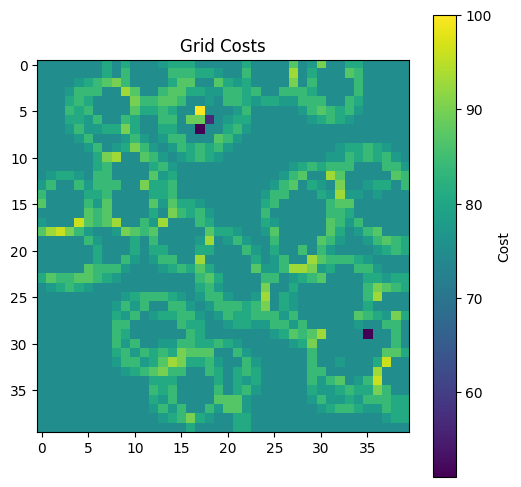

In [31]:
model.plot_grid_costs()

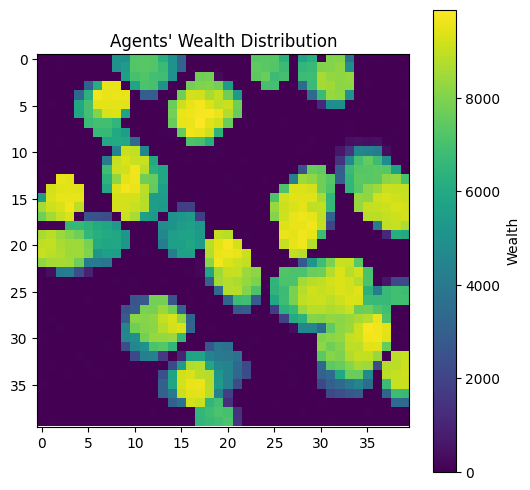

In [32]:
model.plot_agents_wealth()